# PROGETTO DEEP LEARNING



# Il Problema





"Buongiorno,

Il dataset è scaricabile a questo link: <br> https://drive.google.com/file/d/16aLjqwrU-8erdTZ0tBo02_6m85RLy75E/view?usp=sharing
In allegato anche un file che spiega i punti di Repere che dobbiamo andare a localizzare.

Come possibile aiuto, guarderei qualche articolo su keypoint detection e pose estimation. Il nostro obiettivo è leggermente diverso ma la base è la stessa, dobbiamo localizzare dei punti specifici all'interno della immagine.
- https://keras.io/examples/vision/keypoint_detection/
- https://towardsdatascience.com/facial-keypoints-detection-image-and-keypoints-augmentation-6c2ea824a59
- https://www.tensorflow.org/lite/examples/pose_estimation/overview
- https://www.analyticsvidhya.com/blog/2021/10/human-pose-estimation-using-machine-learning-in-python/

L'idea è quella di implementare diverse reti, una per gruppo di punti, per predire le coordinate dei seguenti raggruppamenti (il numero indica l'indice nel file di testo)
- **0,1,4,5 (S,N,A,B)**
- **2,3,7,8 (Sna, Snp, Gn, Go)**
- **9,10,11,12 (U1 e L1 root e tip)**
- **6,13 (pg, mesial)**

Nel file di testo, ogni riga contiene l'**indice del punto**, <u>alcune informazioni inutili</u>, e le **coordinate del punto (le ultime due colonne)**.

Eventualmente, se si ha tempo, confrontando i risultati con una rete che prova a predirli tutti insieme.

Eventualmente, se può servire potenza di calcolo maggiore si può pensare di chiedere accesso a Coka (https://www.fe.infn.it/coka/doku.php?id=start), il cluster di ateneo.

Mi sembra di non dimenticare nulla. Rimango a disposizione
Buon lavoro"
> Prof. Riccardo Zese




---


Altre considerazioni dette a voce:


- Lavoro in ambito di immagini.
- Ho un DS con tante immagini di radiografie
- Su ogni immagine devo analizzare dei punti (14 punti) per poter fare una regressione di valori
- Posso provare con più modelli più piccoli (3-4)
- L'accuratezza se anche è al 60% devo sapere il perchè lo è
- Devo analizzare il DS molto bene!

# Import librerie necessarie

In [ ]:
############################################################################
# IMPORTO LE LIBRERIE NECESSARIE
############################################################################
import numpy as np
import matplotlib.pyplot as plt

import os # per gestire files e cartelle, aprire il Dataset
import zipfile # per estrarre il Dataset

import random # per gestire un po' la casualita'

import pandas as pd # pandas
import seaborn as sns # seaborn, per grafici personalizzati

from matplotlib.cbook import boxplot_stats
# from sklearn.model_selection import train_test_split # per fare lo split in DS di training e di test (forse è inutile)

from tqdm import tqdm  # Provides progress bars during loops and iterations.
from PIL import Image  # Python Image Library per gestire le immagini.

import cv2 # per operare con maggior granularità sulle immagini

# Importazione ed Estrazione del Dataset

In [ ]:
from google.colab import drive # Monto Google drive

# TODO: tutte le volte che ho un DS, è meglio collocarlo in Drive in una certa posizione e montarlo
#       poi, la prima cosa da fare sarà leggere il DS in un Dataframe di pandas.

drive.mount('/content/drive', force_remount=False) # Monto Google Drive a Colab
#############################################################################

# Verifico se esiste la directory in cui e' presente il mio DATASETS.
# Se presente, verifico che ci sia anche lo zip del DS
DATASET_DIR = '/content/drive/My Drive/DATASETS/'
DATASET_NAME_FILE = 'dataset_14_punti_pulito_06072023'
DATASET_NAME_FILE_ZIP = DATASET_DIR + DATASET_NAME_FILE + '.zip'

# Verifico che la directory esista
if os.path.exists( DATASET_DIR ):
    print("\nDirectory trovata: ", DATASET_DIR)
    print("\nContenuto della directory:", os.listdir( DATASET_DIR ) )

    # Verifico che il file zip esista
    if os.path.exists( DATASET_NAME_FILE_ZIP ):
        print("\nFile zip del Dataset presente.")
    else:
        print("\nFile zip del Dataset non trovato.")
else:
    print("\nDirectory non trovata:", DATASET_DIR)

if 'dataset' not in os.listdir( DATASET_DIR ):

  # Estrazione del file: solo quando la cartella 'dataset' non e' gia' presente
  # Questa operazione devo farla solo dopo aver montato Google Drive!
  with zipfile.ZipFile( DATASET_NAME_FILE_ZIP, 'r') as zip_ref:
      zip_ref.extractall( DATASET_DIR )
else:
  print("\nLa cartella e' gia' stata estratta dallo zip\n")

# Controllo del contenuto estratto
# print( os.listdir( DATASET_DIR ) )

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Directory trovata:  /content/drive/My Drive/DATASETS/

Contenuto della directory: ['dataset_14_punti_pulito_06072023.zip', 'Piece_Dimension.csv', 'dataset', '.ipynb_checkpoints', 'dati_completo.csv']

File zip del Dataset presente.

La cartella e' gia' stata estratta dallo zip



# 1) Analisi e Preparazione dati

Noto che il dataset è contenuto nella cartella estratta di nome **'dataset'**.

Per comprendere la struttura del dataset e prepararlo:

- Esploro le immagini: Verifica formato e dimensioni.
- Leggo i file di testo: Controllo come sono salvate le coordinate dei punti.

## Verifiche numeriche

In [ ]:
## Creo il percorso del dataset all'interno della cartella che contiene sia lo zip che la sua estrazione.
DATASET_PATH = DATASET_DIR + 'dataset'

# Lista di tutti i nomi dei files presenti dentro alla cartella in cui e' contenuto il dataset
FILES = os.listdir( DATASET_PATH )
NUM_TOTALE_FILES = len( ( FILES ) )  # conto gli elementi totali presenti dentro la cartella 'dataset'
print(f"\n{'#'*30}\nNumero di files totali: {NUM_TOTALE_FILES}\n{'#'*30}\n")

# Conto quanti files ".jpg" e ".txt" sono presenti
NUM_FILE_JPG : int = len ( list( filter( lambda nome_file : ( ".jpg" in nome_file), FILES ) ) )
NUM_FILE_TXT : int = len ( list( filter( lambda nome_file : ( ".txt" in nome_file ), FILES) ) )
NUM_OTHERS_FILES = NUM_TOTALE_FILES - ( NUM_FILE_JPG + NUM_FILE_TXT )
print(f"\n{'#'*30}\nNumero files '.jpg' totali: {NUM_FILE_JPG}\n{'#'*30}\n")
print(f"\n{'#'*30}\nNumero files '.txt' totali: {NUM_FILE_TXT}\n{'#'*30}\n")
print(f"\n{'#'*30}\nNumero di eventuali altri files rimanenti: {NUM_OTHERS_FILES}\n{'#'*30}\n")



##############################
Numero di files totali: 3199
##############################


##############################
Numero files '.jpg' totali: 1599
##############################


##############################
Numero files '.txt' totali: 1599
##############################


##############################
Numero di eventuali altri files rimanenti: 1
##############################



In [ ]:
## Verifico che ci siano gli stessi numeri, cioè che siano in corrispondenza biunivoca
lista_nomi_files_txt : list[str] = list( filter( lambda nome_file : ( ".txt" in nome_file ), FILES) )
lista_nomi_files_jpg : list[str] = list( filter( lambda nome_file : ( ".jpg" in nome_file), FILES ) )

rimuovi_estensione = lambda nf : int( nf.split('.')[0] )
lista_numeri_files_txt : list[int] = sorted( list( map( rimuovi_estensione, lista_nomi_files_txt ) ) )
lista_numeri_files_jpg : list[int] = sorted( list( map( rimuovi_estensione, lista_nomi_files_jpg ) ) )
stessi_numeri : bool = all( n_txt == n_jpg for n_txt, n_jpg in zip( lista_numeri_files_txt, lista_numeri_files_jpg ) )
print( "Le due liste sono in corrispondenza biunivoca (stessi numeri)" if stessi_numeri else "Ci sono numeri diversi" )

Le due liste sono in corrispondenza biunivoca (stessi numeri)


### Analisi di un'immagine e del relativo file di testo

In [ ]:
# Per visualizzare il singolo file e la singola immagine ad esso associata
n = random.randint(1, NUM_FILE_JPG)  # Numero casuale tra 1 e NUM_FILE_JPG (tanto, appunto, i .jpg sono collegati ai .txt)
# n = 1237 # se provo a mettere n=1237 mi accorgo che non sono presenti l'img e il suo txt


##############################
Analisi dell'immagine numero: 374
##############################

Dimensioni immagine: (616, 616)



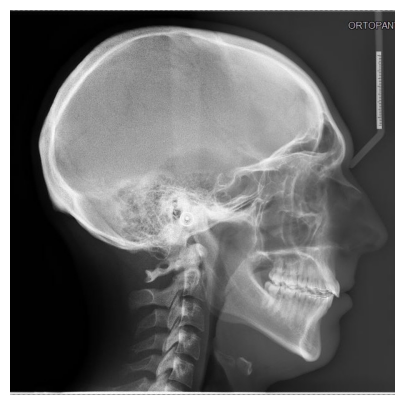

L'immagine è a colori (RGB).


Analisi dell'immagine con OpenCV:

Dimensione array OpenCV: (616, 616, 3)
L'immagine è a COLORI (BGR - 3 canali)

Canali dell'immagine:



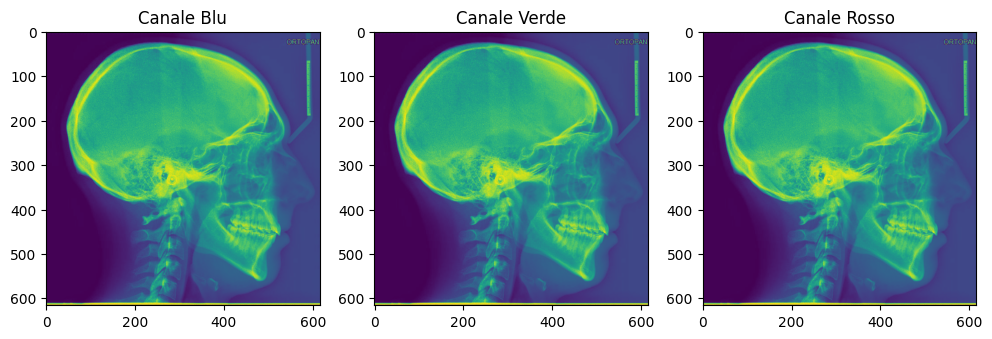


Visualizzazione Istogramma per ciascun canale:



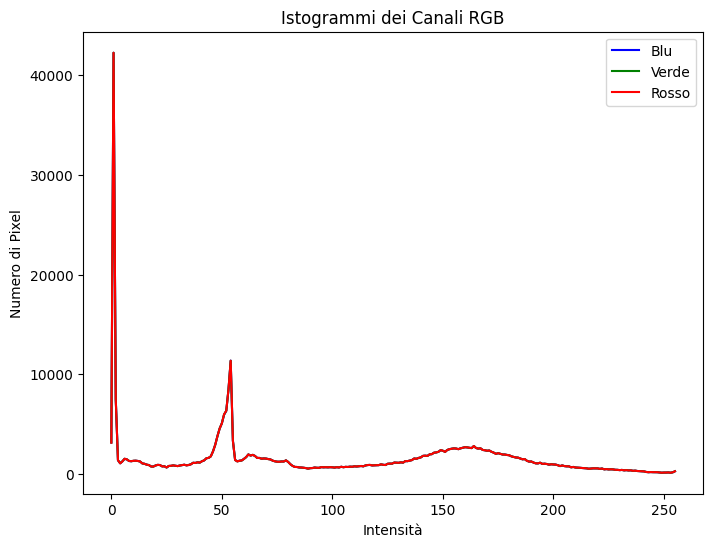

In [ ]:
########################
# Analisi di un'immagine
########################



def controlla_modalita_colore(immagine_PIL):
  '''
  Tramite PIL vado a controllare il numero di canali dell'immagine,
  per verificare se essa è a colori (3 canali) o in scala di grigi (1 canale).
  '''
  if immagine_PIL.mode == 'L':
      print("L'immagine è in scala di grigi.\n")
  elif immagine_PIL.mode == 'RGB':
      print("L'immagine è a colori (RGB).\n")
  elif immagine_PIL.mode == 'RGBA':
      print("L'immagine è a colori (RGBA).\n")
  else:
      print(f"La modalità dell'immagine è: {immagine_PIL.mode}\n")


## Costruisco il path (dinamico), a seconda della singola immagine campione che prelevo dentro il DS
immagine = os.path.join( DATASET_PATH, str(n)+'.jpg')



#### Apertura ed operazioni su immagine
if os.path.exists( immagine ):
    try:
      print(f"\n{'#'*30}\nAnalisi dell'immagine numero: {n}\n{'#'*30}\n")

      ############################################
      ##### Ora analizzo l'immmagine con PIL #####
      ############################################

      img = Image.open( immagine )

      print(f"Dimensioni immagine: {img.size}\n")


      # Quindi provo a mostrarla con matplotlib (perchè in teoria PIL non funziona qui su colab)
      plt.figure( figsize=(5, 5) )
      plt.imshow( img )
      plt.axis('off')  # Rimuove gli assi
      plt.show()

      # Chiamata a funzione di check grayscale o RGB
      controlla_modalita_colore( img )

      ############################################
      ### Ora analizzo l'immmagine con Open CV ###
      ############################################

      print("\nAnalisi dell'immagine con OpenCV:\n")

      # 1) La apro
      img_opencv = cv2.imread( immagine )

      # L'immagine è grayscale o a colori (RGB ad esempio)? lo dovrei vedere dalla shape
      print( f'Dimensione array OpenCV: {img_opencv.shape}' )
      # Se shape è (h, w, 3) --> RGB/BGR
      # Se shape è (h, w) o (h, w, 1) --> Grayscale
      # Se shape è (h, w, 4) --> RGBA

      if len(img_opencv.shape) == 3:
        if img_opencv.shape[2] == 3:
            print("L'immagine è a COLORI (BGR - 3 canali)")
        elif img_opencv.shape[2] == 4:
            print("L'immagine è RGBA (4 canali)")
      else:
          print("L'immagine è in GRAYSCALE (1 canale)")

      # 2) Ne divido i canali
      canale_blu, canale_verde, canale_rosso = cv2.split(img_opencv)
      # canale_blu, canale_verde, canale_rosso = cv2.split(immagine)

      # 3) Visualizzo i canali
      print("\nCanali dell'immagine:\n")

      # Visualizzo i canali
      plt.figure(figsize=(12, 4))

      plt.subplot(1, 3, 1)
      plt.imshow(canale_blu)
      plt.title('Canale Blu')


      plt.subplot(1, 3, 2)
      plt.imshow(canale_verde)
      plt.title('Canale Verde')


      plt.subplot(1, 3, 3)
      plt.imshow(canale_rosso)
      plt.title('Canale Rosso')

      plt.show()

      print("\nVisualizzazione Istogramma per ciascun canale:\n")

      # Calcolo gli istogrammi per ciascun canale
      hist_blu = cv2.calcHist([img_opencv], [0], None, [256], [0, 256])
      hist_verde = cv2.calcHist([img_opencv], [1], None, [256], [0, 256])
      hist_rosso = cv2.calcHist([img_opencv], [2], None, [256], [0, 256])

      # Visualizzo gli istogrammi
      plt.figure(figsize=(8, 6))

      plt.plot(hist_blu, color='blue', label='Blu')
      plt.plot(hist_verde, color='green', label='Verde')
      plt.plot(hist_rosso, color='red', label='Rosso')

      plt.title('Istogrammi dei Canali RGB')
      plt.xlabel('Intensità')
      plt.ylabel('Numero di Pixel')
      plt.legend()

      plt.show()

    except Exception as e:
      print(f"Errore su immagine {n}: {e}")
else:
    print(f"L'immagine {n}.jpg non esiste.")


Vedo che le immagini effettivamente sono a colori, e non in Grayscale

==> potrei portarle in scala di grigi per una miglior velocizzazione dei modelli, senza perdere informazioni.

In [ ]:
####################################
# Analisi del relativo file di testo
####################################

annotazione = os.path.join( DATASET_PATH, str(n)+'.txt') # do il nome del path per trovare il singolo file di testo dentro il DS

if os.path.exists( annotazione ):
  try:
      ## Mi salvo in un DataFrame pandas un SINGOLO file di testo per analizzarne / visualizzarne la struttura
      print(f"\n{'#'*30}\nAnalisi del relativo file di testo numero: {n}\n{'#'*30}\n")

      # Ho notato che la prima riga di ogni file di testo funge da intestazione
      # data = pd.read_csv(sample_annotation, delimiter=',', header=None)
      # Pertanto, con header=0 sto indicando che la prima riga del file è l'intestazione
      struttura_file = pd.read_csv(annotazione, delimiter=',', header=0)

      # Colonne di un singolo file
      struttura_file.columns = ['Index', 'Area', 'Mean', 'Min', 'Max', 'X', 'Y']

      print(f"\n{'#'*30}\nPrime 10 righe del dataframe del singolo file:\n{'#'*30}\n")
      print( struttura_file.head(20) ) # stampo le prime 10 righe

      print(f"\n{'#'*30}\nTipo di dato delle varie colonne:\n{'#'*30}\n")
      print(struttura_file.dtypes) # vedo il tipo di dato delle varie colonne che costituiscono il dataset

      print(f"\n{'#'*30}\nStatistiche riassuntive:\n{'#'*30}\n")
      print( struttura_file.describe() )  # Statistiche riassuntive

      print(f"\n{'#'*30}\nMedia delle coordinate:\n{'#'*30}\n")
      print( struttura_file['X'].mean(), struttura_file['Y'].mean() )  # Media delle coordinate (lavoro per colonne)

  except Exception as e:
    print(f"Errore su file {n}: {e}")
else:
    print(f"Il file {n}.txt non esiste.")


##############################
Analisi del relativo file di testo numero: 1095
##############################


##############################
Prime 10 righe del dataframe del singolo file:
##############################

    Index  Area  Mean  Min  Max       X       Y
0       1     0   135  135  135  1470.0   993.0
1       2     0   163  163  163  2149.5   937.5
2       3     0   216  216  216  1593.5  1481.5
3       4     0   135  135  135  2174.5  1514.5
4       5     0   151  151  151  2107.5  1567.5
5       6     0   180  180  180  2147.5  2012.5
6       7     0   171  171  171  2183.5  2168.5
7       8     0   153  153  153  2105.5  2288.5
8       9     0   157  157  157  1328.5  1760.5
9      10     0   172  172  172  2063.5  1583.5
10     11     0   191  191  191  2171.5  1820.5
11     12     0   232  232  232  2087.5  2087.5
12     13     0   227  227  227  2150.5  1835.5
13     14     0   187  187  187  1905.5  1805.5

##############################
Tipo di dato delle varie 

- Sto notando che tutte le immagini sono di dimensioni (altezza e lunghezza) diverse, quindi sospetto di dover normalizzare / standardizzare.
Ricordo che la scelta tra le due dipende molto dal tipo di dataset con cui ho a che fare.
- La normalizzazione è molto sensibile agli outliers.
- So che la **normalizzazione** è la scelta principe quando lavoro con le **immagini**.

#### Rimozione colonne inutili e verifica dati mancanti


In [ ]:
#########################################################################
# Stampare un Riepilogo del DataFrame (cioè del DS che ho caricato) uso il metodo data.info()
# print("\nRiepilogo del dataframe:\n")
# struttura_file.info()
#########################################################################

# print("\n")
#########################################################################
# Rimozione delle colonne inutili
#########################################################################
# data_cleaned = data.drop( ['Area', 'Mean', 'Min', 'Max'], axis=1 ) # Colonne inutili (come riportato nel testo dell'esercizio)

#########################################################################
# Controllo se ci sono valori mancanti, e nel caso rimuovo le righe
#########################################################################
# missing_values = data_cleaned.isnull().sum()
# print("\nValori mancanti in ogni colonna:\n", missing_values)

# Rimozione di righe con valori mancanti
# data_cleaned = data_cleaned.dropna() # rimuovo i valori mancanti
# print("\nDati puliti:\n", data_cleaned.head() )


# plt.figure( figsize=(10, 5) )
# plt.subplot(1,2,1)
# plt.hist(data_cleaned['X'], bins=20, color='blue', alpha=0.7)
# plt.title('Distribuzione delle coordinate X')


# plt.subplot(1,2,2)
# plt.hist(data_cleaned['Y'], bins=20, color='green', alpha=0.7)
# plt.title('Distribuzione delle coordinate Y')
# plt.show()


## Ulteriore studio
Ora provo a caricare e visualizzare alcune immagini insieme ai keypoints sovrapposti.

Molto bene, dell'output pare non presenti valori mancanti lungo ogni colonna.


Analizzo immagine 504 sovrapponendole i keypoints:



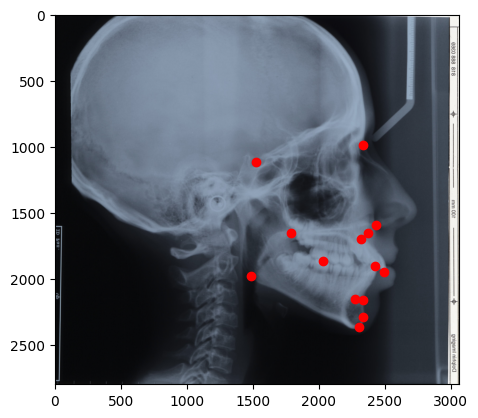

In [ ]:
import cv2 # importo cv2

print(f"\nAnalizzo immagine {n} sovrapponendole i keypoints:\n")

# Carica un'immagine e i relativi keypoints
#Sto ancora considerando data (il dataset di partenza) e non data_cleaned


image = cv2.imread( immagine ) # sfrutto OpenCV
keypoints = [ (x, y) for x, y in zip( struttura_file['X'], struttura_file['Y'] )]  # Considero le colonne 'X' e 'Y' e prendo le coordinate (come delle coppie)

# Plotto l'immagine con i punti sovrapposti

plt.imshow( cv2.cvtColor( image, cv2.COLOR_BGR2RGB) )
for x, y in keypoints:
    plt.scatter(x, y, c='red')
plt.show()


Statistiche sui keypoints:

- Distribuzione delle coordinate: analizzo i valori delle coordinate X e Y per identificare eventuali anomalie.
- Distribuzione per gruppi: confronto i gruppi di punti come definito (0, 1, 4, 5; 2, 3, 7, 8 ecc.).



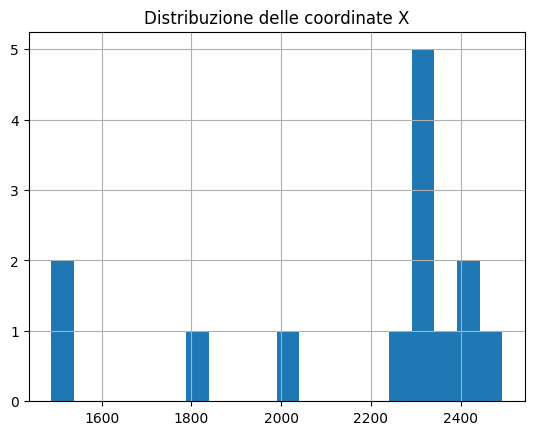

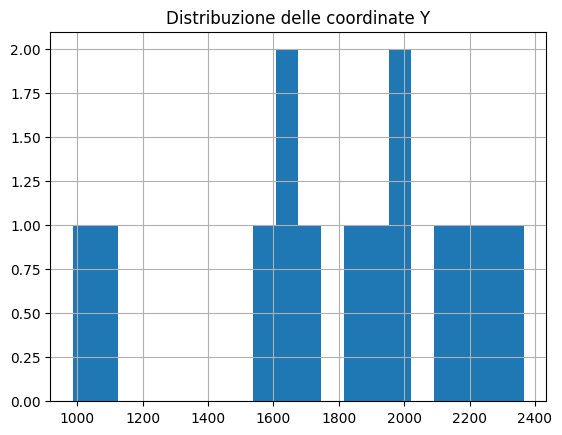

In [ ]:
## Istogrammi delle coordinate
## Da controllare meglio per verificare:
##  -  se le immagini hanno la stessa dimensione
##  -  i canali
##  -  intensità

struttura_file['X'].hist( bins=20 )
plt.title('Distribuzione delle coordinate X')
plt.show()

struttura_file['Y'].hist( bins=20 )
plt.title('Distribuzione delle coordinate Y')
plt.show()

Correlazione tra punti
- Calcolo la correlazione tra i gruppi di keypoints.
- Analizzo la posizione relativa tra i punti, ad esempio la distanza tra il punto S e N.

In [ ]:
from scipy.spatial.distance import euclidean

# # Calcolo distanze tra punti specifici
distanza_SN = euclidean( (struttura_file['X'][0], struttura_file['Y'][0]), (struttura_file['X'][1], struttura_file['Y'][1]) )
print(f"Distanza tra S e N: { distanza_SN }")


Distanza tra S e N: 816.8307658260676


In [ ]:
## TODO: estendere la visualizzazione delle caratteristiche di prima al caso di un campione di più immagini, ad esempio 5-6
## e fare la funzione che mi fa il plot.

# def plot_image_with_keypoints(image_path, keypoints):

#   '''
#   Fa uso di OpenCV per assegnare un colore blu ai valori x ed y
#   '''
#   image = cv2.imread(image_path) # torno a processare l'immagine con OpenCV
#   plt.imshow( cv2.cvtColor( image, cv2.COLOR_BGR2RGB) )
#   for x, y in keypoints: # keypoints l'ho trovato prima
#       plt.scatter(x, y, c='blue', s=10)
#   plt.show()


# # # Itera su più immagini
# for i in range(1, 5):  # Cambia il range per più immagini
#     # print(f"PATH IMMAGINE: {DATASET_PATH}/{i}.jpg")
#     plot_image_with_keypoints(f"{DATASET_PATH}/{i}.jpg", keypoints = [ (x, y) for x, y in zip( struttura_file['X'], struttura_file['Y'] )])

# # NON MI CONVINCE L'OUTPUT: I PUNTI NON SONO DOVE VORREI ?? SONO CORRETTI ?? LO VERIFICO CON LE PROSSIME CELLE



Coordinate Keypoints e Sovrapposizione:
- Se le coordinate X e Y fornite nel file .txt sono corrette, i punti dovrebbero essere posizionati adeguatamente sull'immagine.

Correttezza dei Valori:
- Nel file .txt, i valori delle coordinate sembrano avere numeri grandi, compatibili con la dimensione dell'immagine (ad esempio, X=1288 e Y=660).

Correttezza della Funzione:
- La funzione plot_image_with_keypoints sembra funzionare correttamente, poiché i punti appaiono blu sull'immagine.
Tuttavia, bisogna verificare che:

  - I keypoints siano associati all'immagine giusta.
  - La scala delle coordinate corrisponda alla risoluzione dell'immagine.

## Raccolta dati in DataFrame "master"

Procedo a raccogliere i dati in un DataFrame che presenta il seguente aspetto.

Devo prendermi la lista di tutti i txt presenti nella directory, e per ognuno recuperarmi:

 |path_immagine |punto_1_X |punto_1_Y|punto_2_X |punto_2_Y | ... | punto_14_X | punto_14_Y|
 |------------ |------------ |------------ |------------ |------------ |------------ |------------|------------ |
 | 1.jpg | 11 | 12 | 22 | 23 | ... | 456 | 456
 | 2.jpg | 76 | 55 | 21 | 44 | ... | 89 | 121
 | ... | ... | ... | ... | ... | ... | ... | ...
 | 1599.jpg | 34 | 11 | 83 | 55 | ... | 66 | 99


In [ ]:
## Ottengo tramite list-comprehension una lista di file txt e una lista di immagini
#  Le ordino sulla base dei prefissi
# Sono soltanto le liste dei NOMI dei file, e non del contenuto, ci dovrebbe pensare pandas
# a costruire il dataframe con il contenuto del dataset

lista_files_txt = sorted( [t for t in FILES if t.endswith(".txt") ], key=lambda nf: int(nf.split('.')[0]) )
lista_immagini =  sorted( [i for i in FILES if i.endswith(".jpg") ], key=lambda nf: int(nf.split('.')[0]) )

# A scopo di debug
# print( lista_files_txt )
# print('\n')
# print( lista_immagini )

print( f'Lunghezza lista file TXT: {len( lista_files_txt )}' )
print( f'Lunghezza lista file JPG: {len( lista_immagini )}' )

print( f'Primo file TXT: {lista_files_txt[0]}' )
print( f'Primo file JPG: {lista_immagini[0]}' )

Lunghezza lista file TXT: 1599
Lunghezza lista file JPG: 1599
Primo file TXT: 1.txt
Primo file JPG: 1.jpg


Funzione per prepararmi il dataset nel formato tabellare di cui prima.

In [ ]:
#### Creo un nuovo DataFrame

# dati = pd.DataFrame( columns=['path_img',
#                               'punto_1_X','punto_1_Y',
#                               'punto_2_X', 'punto_2_Y',
#                               'punto_3_X', 'punto_3_Y',
#                               'punto_4_X', 'punto_4_Y',
#                               'punto_5_X', 'punto_5_Y',
#                               'punto_6_X', 'punto_6_Y',
#                               'punto_7_X', 'punto_7_Y',
#                               'punto_8_X', 'punto_8_Y',
#                               'punto_9_X', 'punto_9_Y',
#                               'punto_10_X', 'punto_10_Y',
#                               'punto_11_X', 'punto_11_Y',
#                               'punto_12_X', 'punto_12_Y',
#                               'punto_13_X', 'punto_13_Y',
#                               'punto_14_X', 'punto_14_Y',
#                               ] )

num_punti = 14

### Inizializzo la struttura del mio dataframe: colonne che conterrà
dati : pd.DataFrame = pd.DataFrame( columns=['path_img'] + [f'punto_{n}_{coord}' for n in range(1, num_punti+1) for coord in ('X', 'Y')] )

### Se il file csv che immagazzina i dati del dataframe esiste, allora lo uso per popolare il dataframe
if os.path.exists( DATASET_DIR + 'dati_completo.csv' ):
  dati = pd.read_csv( DATASET_DIR + 'dati_completo.csv' )

### Altrimenti lo costruisco


def normalizza_coordinate_immagine(X : pd.Series, Y : pd.Series) -> tuple[pd.Series]:
  '''
  Per l' immagine a cui viene applicata, normalizza le coordinate:
  Divido le coordinate x per la larghezza e le y per l'altezza.

  Args:
    - X: pd.Series, contiene le coordinate X dei punti. Queste si trovano nel file di testo associato all'immagine a cui mi sto riferendo.
    - Y: pd.Series, contiene le coordinate Y dei punti. Queste si trovano nel file di testo associato all'immagine a cui mi sto riferendo.
  '''

  # Apro l'immagine con PIL
  with Image.open( immagine ) as img:
    width, height = img.size

  X_norm = X / width
  Y_norm = Y / height

  return (X_norm, Y_norm)





def prepara_dataset_completo(DIR_ANNOTAZIONI, lista_nomi_files_jpg : list[str], lista_nomi_files_txt : list[str], dati : pd.DataFrame) -> pd.DataFrame:
  '''
  Si occupa di riempire il DataFrame con i soli dati di interesse.
  Args:
  DIR_ANNOTAZIONI: directory in cui sono salvati tutti i file di testo che annotano ogni singola immagine.
  lista_nomi_files_jpg: lista ordinata dei nomi di tutte le immagini presenti nel dataset.
  lista_nomi_files_txt: lista ordinata dei nomi di tutte i file di testo presenti nel dataset.
  dati: pd.DataFrame, dataframe pandas da usare per immagazzinare i dati.
  '''

  ## Definizione del dataframe
  # num_punti = 14
  # dati : pd.DataFrame = pd.DataFrame(
  #     columns=['path_img'] +
  #             [f'punto_{n}_{coord}' for n in range(1, num_punti+1) for coord in ('X', 'Y')] # +1 per comprendere anche il 14°-esimo punto nel range
  # )


  for t, i in zip( lista_nomi_files_txt, lista_nomi_files_jpg ): # posso usare la zip dato che ho appurato che le due liste hanno la medesima lunghezza
    try:

      ### Inizio col definirmi la variabile che rappresenta la singola riga del DF
      ##  La prima colonna deve avere il nome dell'immagine
      riga = {'path_img': i } # costruisco il dizionario per questa riga

      ##  Le altre colonne, ciascuna deve avere la coordinata
      df_txt = pd.read_csv( f"{DIR_ANNOTAZIONI}/{t}", delimiter=',', header=0 ) # prima colonna è quella delle intestazioni

      ##  Recupero le coordinate X ed Y rispettivamente
      X : pd.Series = df_txt['X'].values
      Y : pd.Series = df_txt['Y'].values

      ## TODO: qui molto probabilmente devo occuparmi di normalizzare le coordinate, in un intervallo come
      ## [0,1] o [-1, 1]
      #X, Y = normalizza_coordinate_immagine(X, Y)

      ### TODO: sto saltando la chiamata a normalizza_coordinate
      ### perchè altrimenti quando sotto visualizzo la griglia, mi da problemi


      riga.update( {f'punto_{idx+1}_X' : x for idx, x in enumerate(X)} )
      riga.update( {f'punto_{idy+1}_Y' : y for idy, y in enumerate(Y)} )

      ##  Aggiungo la riga al dataframe
      dati.loc[ len(dati) ] = riga

    except FileNotFoundError:
        print(f"Immagine non trovata per {t}. Salto.")
    except Exception as e:
          print(f"Errore durante l'elaborazione di {t}: {e}")

  # Restituisco il dataframe creato
  return dati



### Richiamo la funzione, solo se non esiste e contiene il giusto numero di righe
# dati = prepara_dataset_completo( DATASET_PATH, lista_nomi_files_jpg, lista_nomi_files_txt, dati )
if not os.path.exists( DATASET_DIR + 'dati_completo.csv' ) or dati.shape[0] != NUM_FILE_JPG: # il giusto numero di righe me lo dice la shape

  ### chiamata alla funzione che me lo prepara
  dati = prepara_dataset_completo( DATASET_PATH, lista_immagini, lista_files_txt, dati )

  ### Salvo il dataframe su file .csv dentro Drive
  dati.to_csv(DATASET_DIR + 'dati_completo.csv', index=False)


Visualizzo le prima 1000 righe:


In [ ]:
dati.head( 1000 )

,path_img,punto_1_X,punto_1_Y,punto_2_X,punto_2_Y,punto_3_X,punto_3_Y,punto_4_X,punto_4_Y,punto_5_X,...,punto_10_X,punto_10_Y,punto_11_X,punto_11_Y,punto_12_X,punto_12_Y,punto_13_X,punto_13_Y,punto_14_X,punto_14_Y
0,1.jpg,1288.0,660.0,2079.500,607.500,1495.500,1167.500,2075.5,1167.500,2019.500,...,1951.500,1231.500,2091.500,1507.500,1911.500,1699.500,2031.5,1467.500,1703.500,1451.500
1,2.jpg,1176.0,676.0,1947.500,647.500,1371.500,1127.500,1971.5,1163.500,1931.500,...,1891.500,1263.500,1959.500,1507.500,1767.500,1707.500,1931.5,1507.500,1623.500,1451.500
2,3.jpg,430.0,266.0,708.833,226.167,519.500,420.833,715.5,423.500,696.833,...,671.500,426.167,716.833,516.833,640.833,572.833,699.5,496.833,572.833,490.167
3,4.jpg,1228.0,780.0,1963.500,707.500,1427.500,1235.500,1983.5,1215.500,1927.500,...,1835.500,1263.500,1967.500,1503.500,1771.500,1691.500,1943.5,1483.500,1587.500,1427.500
4,5.jpg,1236.0,728.0,1987.500,555.500,1471.500,1135.500,2051.5,1067.500,1967.500,...,1919.500,1131.500,2023.500,1351.500,1875.500,1535.500,1991.5,1319.500,1667.500,1315.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1047.jpg,1566.0,783.0,2241.500,728.500,1745.500,1172.500,2267.5,1212.500,2197.833,...,2148.500,1265.500,2223.167,1485.500,2049.833,1626.833,2180.5,1444.167,1891.167,1385.500
996,1048.jpg,507.0,1047.0,869.833,912.167,678.500,1248.500,972.5,1212.500,968.500,...,945.500,1229.500,987.500,1339.500,971.500,1435.500,974.5,1337.500,841.500,1339.500
997,1049.jpg,564.0,897.0,1238.500,689.500,746.500,1312.500,1372.5,1222.500,1346.500,...,1240.500,1227.500,1384.500,1470.500,1258.500,1725.500,1345.5,1476.500,1078.500,1485.500
998,1050.jpg,1029.0,393.0,1739.500,341.500,1227.833,827.167,1774.5,897.833,1710.500,...,1686.833,958.833,1782.833,1204.167,1688.167,1408.167,1805.5,1193.500,1536.167,1168.167


Verifico se ci sono dei valori mancanti o anomali

In [ ]:
dati.isna().sum()
dati.describe()

,punto_1_X,punto_1_Y,punto_2_X,punto_2_Y,punto_3_X,punto_3_Y,punto_4_X,punto_4_Y,punto_5_X,punto_5_Y,...,punto_10_X,punto_10_Y,punto_11_X,punto_11_Y,punto_12_X,punto_12_Y,punto_13_X,punto_13_Y,punto_14_X,punto_14_Y
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,...,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,977.657170,712.658175,1607.368336,598.890492,1176.033258,1091.573628,1666.516822,1071.854060,1619.638528,1124.188998,...,1562.039436,1110.572161,1661.230817,1327.117063,1517.104958,1500.160159,1625.429222,1309.562695,1373.238643,1290.641757
std,491.706084,321.132564,693.782798,290.855242,548.309578,444.209173,713.338657,440.525476,696.009448,457.843777,...,676.001072,451.995191,711.851982,529.860615,664.327416,592.253943,700.297857,522.492226,616.820840,515.576896
min,13.271000,7.376000,21.524000,6.524000,15.347000,12.382000,21.876000,12.559000,20.959000,13.335000,...,20.500000,13.229000,21.524000,15.559000,19.653000,17.006000,20.853000,15.065000,17.641000,14.888000
25%,538.000000,442.500000,1030.188500,371.500000,679.329500,808.913000,1086.217000,778.230500,1053.075500,835.622000,...,995.534500,823.000000,1085.000000,1018.500000,971.500000,1173.346000,1047.500000,1004.000000,839.500000,986.333500
50%,1077.000000,711.500000,1756.500000,599.500000,1289.500000,1145.500000,1823.500000,1136.500000,1767.500000,1195.500000,...,1703.500000,1172.500000,1810.500000,1409.500000,1646.500000,1601.500000,1769.500000,1388.500000,1484.500000,1361.500000
75%,1286.500000,912.000000,2045.579500,787.668500,1535.000000,1351.160000,2120.000000,1323.083500,2067.000000,1380.166500,...,1994.500000,1366.333500,2117.833500,1620.833500,1957.500000,1824.500000,2071.511500,1600.000000,1774.000000,1588.500000
max,3454.000000,2248.000000,5159.247000,2031.500000,3881.799000,3113.500000,5230.613000,3149.500000,5052.198000,3269.500000,...,4888.057000,3191.500000,5130.701000,3743.500000,4745.325000,4187.500000,5080.745000,3737.500000,4459.862000,3689.500000


Noto che:
- Ho per ogni colonna esattamente `1599` valori di `conteggio`, quindi non ci sono valori mancanti.
- Leggendo i valori `min` e `max` mi sembra di capire che le X variano fino a circa 5000 px e le Y fino a circa 4200 px. Le dimensioni sono piuttosto grandi, e come visto prima ogni immagine ha dimensioni diverse.
- Dalla `media` dei punti vedo che ad esempio:
  - punto_1 è intorno a (978, 713)
  - punto_14 è intorno a (1373, 1291)
  - punto_4 è intorno a (1666, 1072)

I punti sembrano distribuiti su un'area che si sposta verso destra e verso il basso (come atteso per i punti del cranio delle cefalometrie)

- `std`: la deviazione standard mi indica come variano i punti.
  - alcuni punti, come punto_2, punto_4, punto_11 hanno std nelle ascisse > 700 px.
  - altri punti, come il punto_1 hanno std per le Y < 330px

Quindi, alcuni punti variano molto di più, probabilmente perchè:
  - sono in zone più mobili (come mandibola o estremità)
  - oppure le immagini non sono perfettamente allineate



In [ ]:
# import seaborn as sns

# for i in range(1, 15):
#     sns.kdeplot(dati[f"punto_{i}_X"], label=f"P{i}_X", fill=True, alpha=0.3)
# plt.legend()
# plt.title("Distribuzione X dei punti")
# plt.show()


# for i in range(1, 15):
#     sns.kdeplot(dati[f"punto_{i}_Y"], label=f"P{i}_Y", fill=True, alpha=0.3)
# plt.legend()
# plt.title("Distribuzione Y dei punti")
# plt.show()

#### Visualizzazione punti sovrapposti

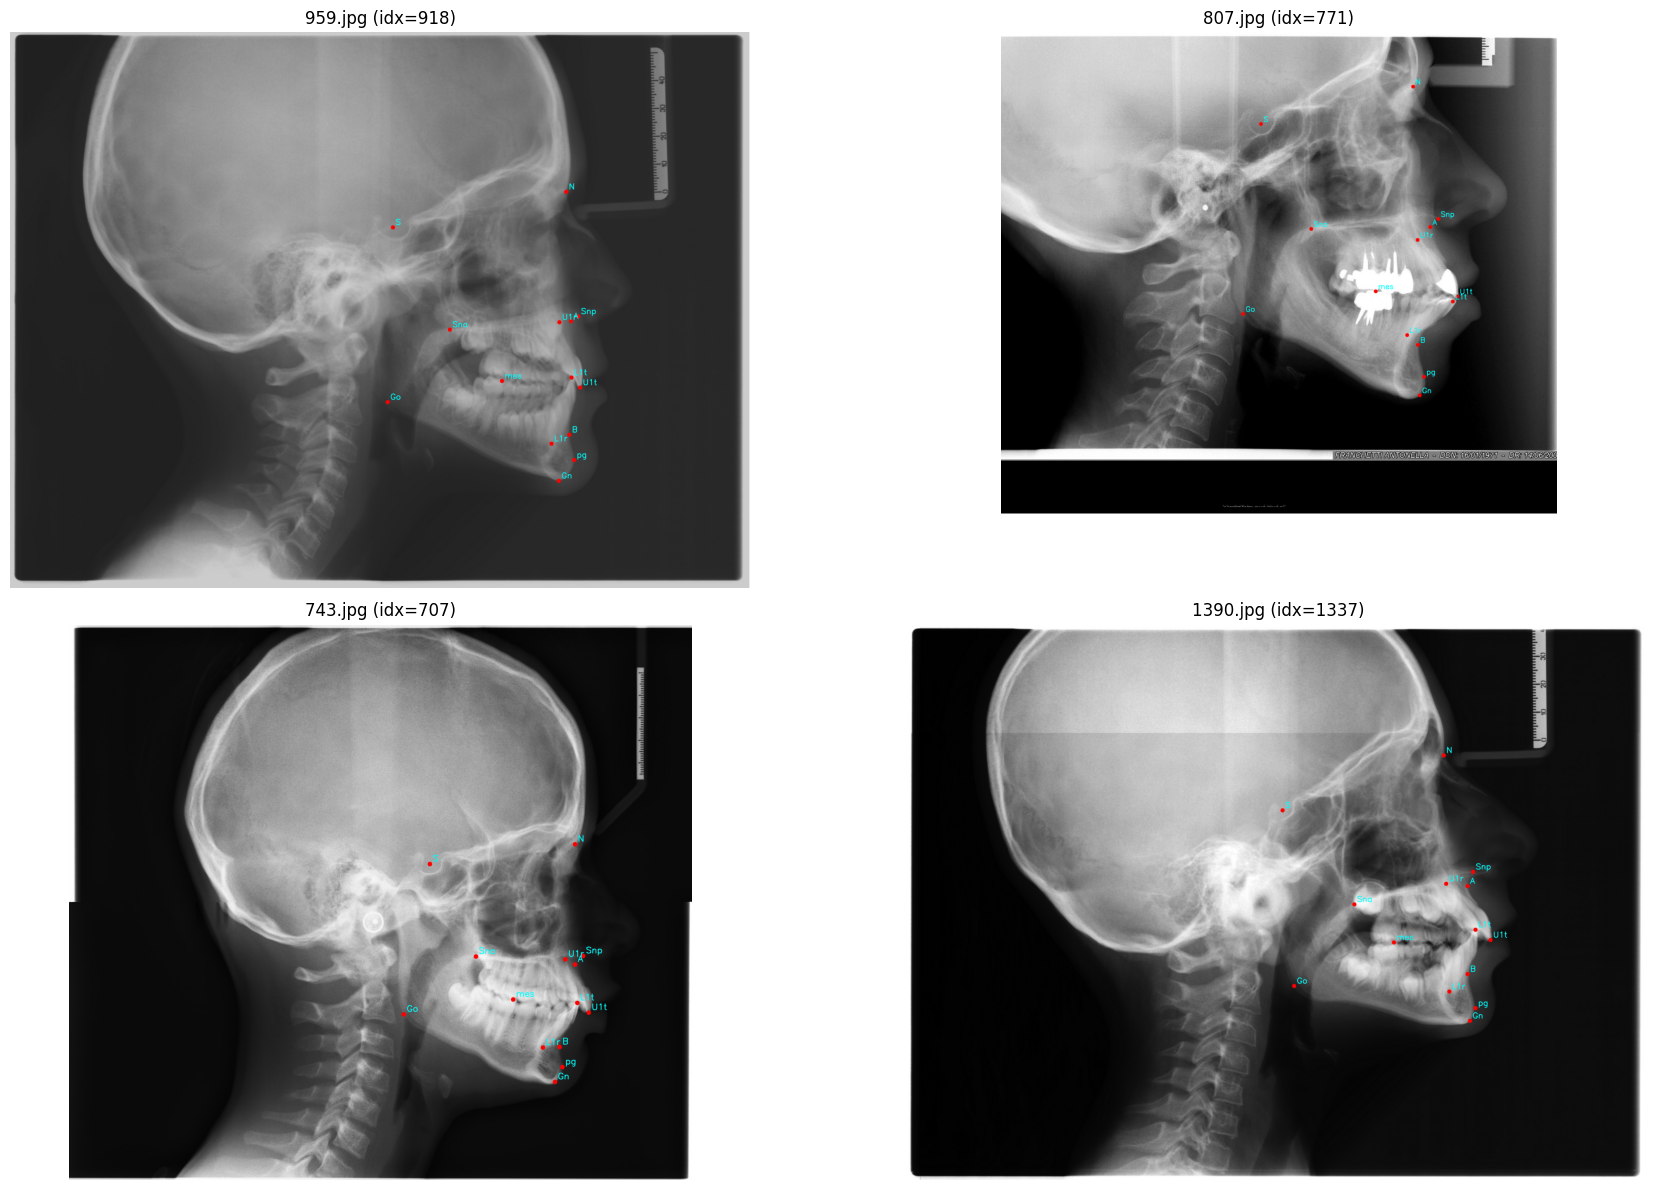

In [ ]:

# Uso una lista anzichè un dizionario in modo da essere indipendente dall'indice.
# Infatti, nel testo del problema l'indica inizia da 0 e finisce a 13, mentre
# nei files di testo inizia da 1 e finisce a 14.
etichette_punti : list[str] = ["S","N","Sna","Snp","A","B","pg","Gn","Go","U1r","U1t","L1r","L1t","mes"] # prima avevo questo
# etichette_punti : list[str] = ["S","N","Sna","Snp","A","B","pg","Gn","Go","U1r","L1r","U1t","L1t","mes"] #



def mostra_punti_annotati_random(df, path_base=DATASET_PATH, n_immagini=10):
    """
    Mostra una griglia di immagini casuali con i punti sovrapposti e le relative sigle anatomiche corrette.

    Args:
    - df: DataFrame Pandas contenente 'path_immagine' e colonne punto_<n>_<X|Y>
    - path_base: percorso della cartella contenente le immagini (es. 'dataset/images')
    - n_immagini: numero di immagini da visualizzare (default = 10)
    """

    # Seleziono n immagini casuali
    sample_df = dati.sample( n=n_immagini, random_state=random.randint(0,10000) ).reset_index(drop=True)

    # Calcola le dimensioni della griglia
    cols = 2
    rows = (n_immagini + cols - 1) // cols # // mi calcola la divisione senza resto

    # Ho bisogno di più sotto-plots
    fig, axes = plt.subplots(rows, cols, figsize=(20, 12))
    axes = axes.flatten()

    for idx, (i, row) in enumerate(sample_df.iterrows()): # itero sulle righe del DF => ogni riga == un'immagine
        img_path = f"{path_base}/{row['path_img']}"

        # Leggo l'immagine con OpenCV
        img = cv2.imread(img_path)
        if img is None:
            print(f"Immagine non trovata: {img_path}")
            continue

        # Recupero altezza e larghezza rispettivamente dell'immagine
        height, width = img.shape[0], img.shape[1]

        # Disegno i punti
        for j in range(1, num_punti + 1): # Scorro sulle colonne, a partire dalla 2° che ha il primo punto

            # Unpacking delle coordinate: Open CV accetta le coordinate come numeri interi,
            # altrimenti non riesce a calcolare il centro del cerchio
            x, y = int( row[f"punto_{j}_X"]  ), int( row[f"punto_{j}_Y"]   )

            # print('\n')
            # print("X: ", x, " Y: ", y )

            cv2.circle( img, (x, y), 8, (0, 0, 255), -1 )   # cerchio rosso
            # cv2.circle(, img, coord, raggio, colore, -1) # coord valeva 5

            # Scrivo il testo
            cv2.putText(
                img,
                etichette_punti[j-1],
                (x + 10, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                1.0, # prima era 0.6
                (255, 255, 0),  # giallo
                2
            )

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax = axes[idx]
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"{row['path_img']} (idx={df.index[df['path_img']==row['path_img']][0]})")


    # Nascondo eventuali assi vuoti
    for k in range(idx + 1, len(axes)):
        axes[k].axis("off")

    # Mostro a video
    plt.tight_layout()
    plt.show()

# passo alla prossima immagine


mostra_punti_annotati_random(
    dati,
    path_base=DATASET_PATH,  # es. "dataset/images"
    n_immagini=4           # quante immagini mostrare
)

Confrontando questi risultati con altri che ho trovato sul web, il posizionamento dei punti mi sembra corretto, ad eccezione di Sna e Snp che mi sembrano invertiti...

Inoltre, mi pare che per le immagini senza una risoluzione abbastanza alta alcuni punti si sovrappongono.

# Modelli

In [ ]:
## Ogni modello avrà un numero di output pari a len( GRUPPO )*2
## Mi conviene salvarmi / isolarmi i punti in diversi "sotto-dataframe", ognuno associato allo specifico modello
## Credo che questo sia importante anche per poter avere una maggior granularità verso lo specifico gruppo di punti.
## Infatti, se per caso trovo difficoltà per un

RAGGRUPPAMENTI = {
    "GRUPPO1": [0, 1, 4, 5],    # S, N, A, B
    "GRUPPO2": [2, 3, 7, 8],    # Sna, Snp, Gn, Go
    "GRUPPO3": [9, 10, 11, 12], # U1r, U1t, L1r, L1t
    "GRUPPO4": [6, 13]          # Pg, Mesial
}

## Mi salvo tutti gli indici dei raggruppamenti per il modello più generale
lista_indici_di_tutti_i_punti = sum( RAGGRUPPAMENTI.values(), [] )



## Creo diversi DF ognuno correlato ad uno specifico gruppo di punti
def crea_sottodataframe_per_gruppo(dati_completi, nome_gruppo) -> pd.DataFrame:
    """
    Crea sotto-dataframe per il raggruppamento specificato.

    Args:
      dati_completi: dataframe "master" di partenza, completo di tutti i punti.
      nome_gruppo: chiave del dizionario che ha per valori la lista dei punti di interesse per ognuno dei raggruppamenti.
    """

    # Seleziona tutte le colonne relative ai punti del gruppo (sia X che Y)
    colonne_selezionate = ['path_img']  # Mantengo sempre il path dell'immagine

    for idx in RAGGRUPPAMENTI[nome_gruppo]:
        punto_numero = idx + 1  # Converto da indice 0-based a numero punto 1-based
        colonne_selezionate.extend( [f'punto_{punto_numero}_X', f'punto_{punto_numero}_Y'] )

    # Crea il sotto-dataframe, selezionando solo le colonne di interesse, e facendo una copia di quello originale
    dataframe_gruppo = dati_completi[colonne_selezionate].copy()

    return dataframe_gruppo



dati_gruppo_1 : pd.DataFrame = crea_sottodataframe_per_gruppo(dati, "GRUPPO1")
dati_gruppo_2 : pd.DataFrame = crea_sottodataframe_per_gruppo(dati, "GRUPPO2")
dati_gruppo_3 : pd.DataFrame = crea_sottodataframe_per_gruppo(dati, "GRUPPO3")
dati_gruppo_4 : pd.DataFrame = crea_sottodataframe_per_gruppo(dati, "GRUPPO4")

print( "\nDATI COMPLETI:\n", dati.head(3) )

print( "\nGRUPPO 1:\n" , dati_gruppo_1.head(3) )
print( "\nGRUPPO 2:\n" , dati_gruppo_2.head(3) )
print( "\nGRUPPO 3:\n" , dati_gruppo_3.head(3) )
print( "\nGRUPPO 4:\n" , dati_gruppo_4.head(3) )

lista_dati_raggruppamenti : list[pd.DataFrame] = [dati_gruppo_1, dati_gruppo_2, dati_gruppo_3, dati_gruppo_4]

# for df_gruppo in lista_dati_raggruppamenti, i in range(1, len(lista_dati_raggruppamenti)+1):
#   df_gruppo.to_csv(DATASET_DIR + f'dati_gruppo_{i}.csv', index=False)

## Lista di bool come "sentinella" per vedere se tutti sono stati
lista_files_dati_gruppi_creati : list[bool] = [ os.path.exists( DATASET_DIR + f'dati_gruppo_{i}.csv' ) for i in range(1, len(lista_dati_raggruppamenti)+1) ]

# Se ho creato correttamente tutti i file csv dei gruppi
if not all( lista_files_dati_gruppi_creati ):
  print("\n")
  for i, df_gruppo in zip( range(1, len(lista_dati_raggruppamenti)+1), lista_dati_raggruppamenti ):
      df_gruppo.to_csv(DATASET_DIR + f'dati_gruppo_{i}.csv', index=False)
      print(f"Salvato file: dati_gruppo{i}.csv\n")

# lista_dati_raggruppamenti : list[pd.DataFrame] = [ crea_sottodataframe_per_gruppo(dati, chiave) for chiave in RAGGRUPPAMENTI.keys()  ]

# print( "\nDATI COMPLETI:\n", dati.head(3) )

# for dati_gruppo, i in lista_dati_raggruppamenti, range(1, len(lista_dati_raggruppamenti)+1):
#   print( f"\nDATI GRUPPO {i}:\n", dati_gruppo.head(3) )
#lista_dati_raggruppamenti.map( lambda dati_gruppo : dati_gruppo.head(3) )


In [ ]:
lista_indici_di_tutti_i_punti

### PyTorch e definizione dei modelli

In [ ]:
import torch  # Per il progetto uso PyTorch.
import torch.nn as nn  # Offre i vari layers per le RN e funzioni.
import torch.optim as optim  # Algoritmi di ottimizzazione.
import torch.nn.functional as F  # Per le funzioni di loss e anche per le funzioni di attivazione.
from torch.utils.data import Dataset, DataLoader  # Per importare il DS.

import torchvision.transforms as transforms  # Offre le principali trasformazioni per l'immagine.
import torchvision.models as models  # Modelli Pre-trained per task di computer vision.


from datetime import datetime

## Tensorboard
from torch.utils.tensorboard import SummaryWriter

## Albumentations per Data Augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2


from sklearn.model_selection import train_test_split

## Perchè HRNet è disponibile tramite timm
import timm  # HRNet disponibile tramite timm



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Prevedo di creare un custom Dataset, con la relativa classe, che possa gestire:
- caricamento immagine
- ridimensionamento
- augmentations con **Albumentations**
- normalizzazione
- restituzione di tensore + vettore di coordinate normalizzate in [0,1]

In [ ]:
class RepereKeypointsDataset(Dataset):
    def __init__(self, df, img_dir, indices, img_size=512, transforms=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.indices = indices
        self.img_size = img_size
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join( self.img_dir, row["path_img"] )

        # Leggo l'immagine con OpenCV
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


        h, w = img.shape[:2]
        # estrai le coordinate solo per i punti di interesse
        coords = []
        for i in self.indices:
            x = float( row[f"punto_{i+1}_X"] )
            y = float( row[f"punto_{i+1}_Y"] )
            coords.append( (x, y) )

        coords = np.array( coords, dtype=np.float32 )

        ## Augmentations e Normalizzazione
        if self.transforms:
            transformed = self.transforms(image=img, keypoints=coords)
            img = transformed["image"]
            coords = np.array( transformed["keypoints"], dtype=np.float32 )

        # Normalizza le coordinate tra [0,1]
        coords[:, 0] /= self.img_size
        coords[:, 1] /= self.img_size

        coords = coords.flatten()  # [x1,y1,x2,y2,...]
        return img, torch.tensor( coords, dtype=torch.float32 )


### Albumentations pipeline




In [ ]:
def get_transforms(img_size=512):
    return A.Compose([
        A.Resize(img_size, img_size),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.GaussianBlur(p=0.2),
        A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
        ToTensorV2()
    ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

### Modello HRNet per regressione diretta

In [ ]:
class HRNetRegressor(nn.Module):
    def __init__(self, backbone_name="hrnet_w48", num_outputs=8):
        super().__init__()
        # Usa HRNet pre-addestrato da TIMM
        # (Installabile con: pip install timm)
        self.backbone = timm.create_model(backbone_name, pretrained=True, features_only=True)
        out_ch = self.backbone.feature_info[-1]["num_chs"]
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(out_ch, num_outputs)

    def forward(self, x):
        feats = self.backbone(x)[-1]
        pooled = self.global_pool(feats).flatten(1)
        out = self.fc(pooled)
        return out

### Funzioni di Tranining e Validazione

In [ ]:
def train_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    for imgs, coords in loader:
        imgs, coords = imgs.to(device), coords.to(device)
        preds = model(imgs)
        loss = loss_fn(preds, coords)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    return running_loss / len(loader.dataset)


def val_epoch(model, loader, loss_fn, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, coords in loader:
            imgs, coords = imgs.to(device), coords.to(device)
            preds = model(imgs)
            loss = loss_fn(preds, coords)
            val_loss += loss.item() * imgs.size(0)
    return val_loss / len(loader.dataset)

### Training loop completo con TensorBoard e checkpoint

In [ ]:
def train_model(df, img_dir, indices, model_name="model", img_size=512, batch_size=8, epochs=50):

    ## Split train/val
    df_train, df_val = train_test_split(df, test_size=0.1, random_state=42)

    train_ds = RepereKeypointsDataset(df_train, img_dir, indices, img_size, transforms= get_transforms(img_size))
    val_ds   = RepereKeypointsDataset(df_val, img_dir, indices, img_size, transforms=   get_transforms(img_size))

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    num_points = len(indices)
    num_outputs = num_points * 2  # X e Y per punto

    ## Testa di regressione
    model = HRNetRegressor(num_outputs=num_outputs).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    loss_fn = nn.MSELoss()

    # TensorBoard + checkpoint
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    log_dir = f"runs/{model_name}_{timestamp}"
    writer = SummaryWriter(log_dir)
    best_loss = float("inf")

    for epoch in range(1, epochs + 1):

        train_loss = train_epoch(model, train_loader, optimizer, loss_fn, device)
        val_loss = val_epoch(model, val_loader, loss_fn, device)

        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("Loss/val", val_loss, epoch)

        print(f"[{epoch:03d}/{epochs}] train={train_loss:.4f} | val={val_loss:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), f"{model_name}_best.pth")
            print(f"Nuovo best model salvato ({val_loss:.4f})")

    writer.close()
    print("Training completato.")


In [ ]:
print( RAGGRUPPAMENTI )

print( lista_dati_raggruppamenti )

Allenamento dei 4 modelli

In [ ]:
# Allena ciascun modello
# for (name, idxs), k in zip(RAGGRUPPAMENTI.items(), range(0, len(RAGGRUPPAMENTI)+1)):
#     print(f"\n Training modello {name} (punti {idxs})")
#     train_model(lista_dati_raggruppamenti[k], DATASET_PATH, indices=idxs, model_name=f"HRNet_{name}", img_size=512, batch_size=8, epochs=5)

# Modello generale
print("\n🌐 Training modello generale (tutti i punti)")
train_model(dati, DATASET_PATH, indices=lista_indici_di_tutti_i_punti, model_name="HRNet_All", img_size=512, batch_size=8, epochs=5)